In [1]:
# Loading the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

In [2]:
# Loading the dataset and preparing it for training
train_path = '../archive/seg_train/seg_train/'
test_path = '../archive/seg_test/seg_test/'

# Loading the dataset
import os
import cv2
from tqdm import tqdm

def load_images(path):

    X = []
    y = []

    for folder in os.listdir(path):
        files = os.listdir(path + folder)
        for file in tqdm(files):
            img = cv2.imread(path + folder + '/' + file)
            img = cv2.resize(img, (150, 150))
            X.append(img)
            y.append(folder)
    
    X = np.array(X)
    y = np.array(y)

    return X, y

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

classes_names = np.unique(y_train)

# Encoding the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One hot encoding the target variable
y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

# Splitting the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=0)

# Normalizing the images
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

# Data Augmentation

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

100%|██████████| 510/510 [00:00<00:00, 2306.46it/s]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

2024-06-17 16:42:01.658367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-06-17 16:42:01.743420: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


351/351 [==============================] - 669s 2s/step - loss: 0.8953 - accuracy: 0.6622 - val_loss: 0.4988 - val_accuracy: 0.8308
Epoch 2/10
351/351 [==============================] - 605s 2s/step - loss: 0.6005 - accuracy: 0.7808 - val_loss: 0.4751 - val_accuracy: 0.8336
Epoch 3/10
351/351 [==============================] - 619s 2s/step - loss: 0.5423 - accuracy: 0.8034 - val_loss: 0.4095 - val_accuracy: 0.8557
Epoch 4/10
351/351 [==============================] - 632s 2s/step - loss: 0.5189 - accuracy: 0.8100 - val_loss: 0.4180 - val_accuracy: 0.8475
Epoch 5/10
351/351 [==============================] - 618s 2s/step - loss: 0.5028 - accuracy: 0.8140 - val_loss: 0.4037 - val_accuracy: 0.8596
Epoch 6/10
351/351 [==============================] - 623s 2s/step - loss: 0.4875 - accuracy: 0.8189 - val_loss: 0.3949 - val_accuracy: 0.8579
Epoch 7/10
351/351 [==============================] - 646s 2s/step - loss: 0.4726 - accuracy: 0.8252 - val_loss: 0.3867 - val_accuracy: 0.8497
Epoch 8/10

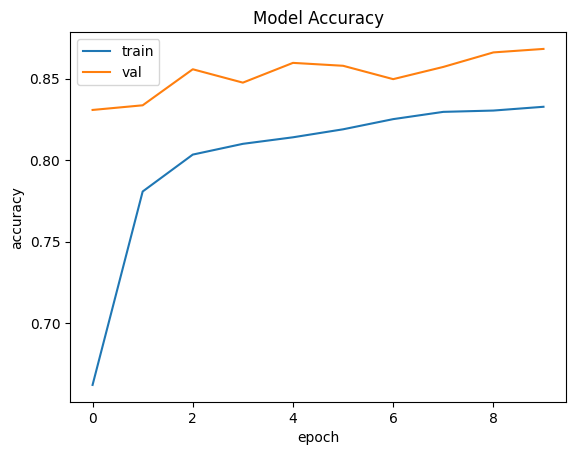

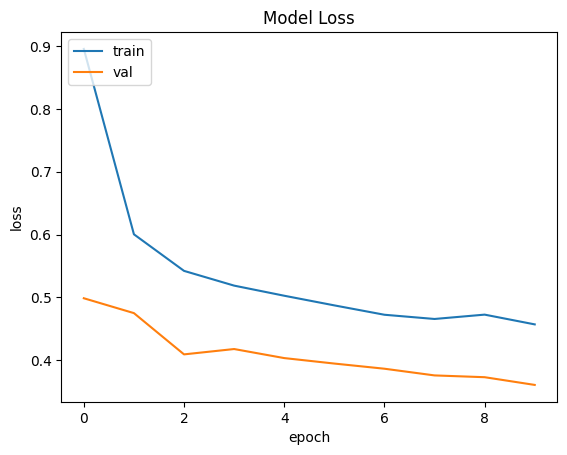

In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('vgg16_data_augmented.h5', save_best_only=True)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_val, y_val), epochs=10, callbacks=[early_stopping, model_checkpoint])

# Plotting the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
# Loading the best model and evaluating it on the test set
from keras.models import load_model

model = load_model('vgg16_data_augmented.h5')

test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
predictions = model.predict(X_test)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

94/94 [==============================] - 129s 1s/step
Test loss: 0.3519079089164734
Test accuracy: 0.8676666617393494


F1 Score:  0.8682227357501244
Precision:  0.8697741794489867
Recall:  0.8676666666666667
Accuracy:  0.8676666666666667


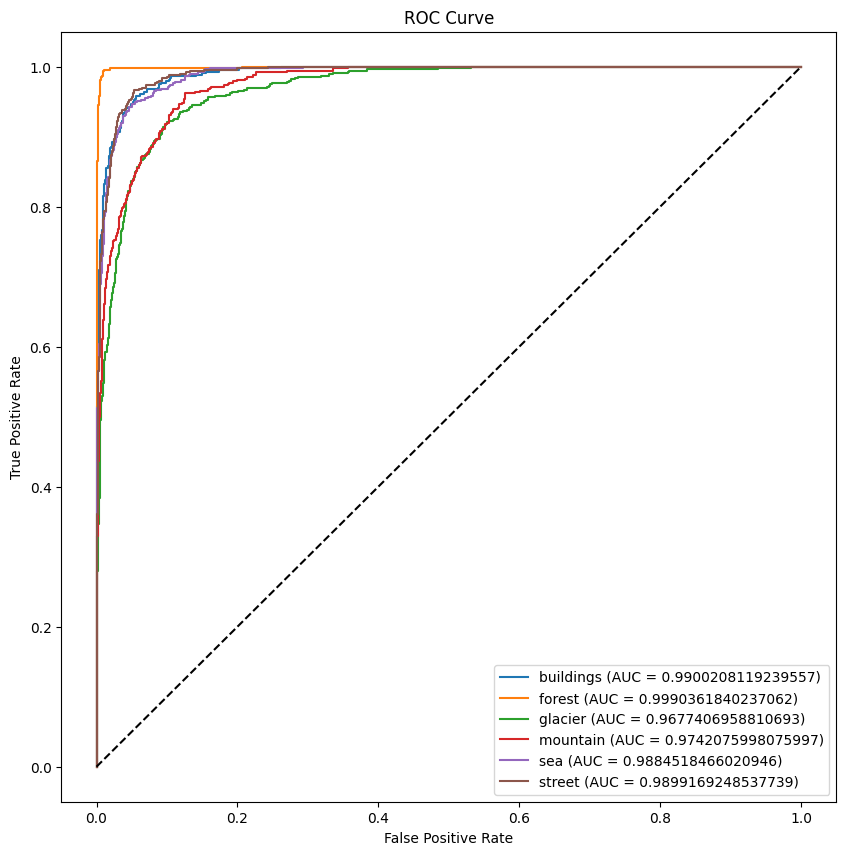

              precision    recall  f1-score   support

   buildings       0.87      0.89      0.88       437
      forest       0.97      0.96      0.96       474
     glacier       0.78      0.85      0.81       553
    mountain       0.82      0.80      0.81       525
         sea       0.90      0.84      0.87       510
      street       0.89      0.88      0.88       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



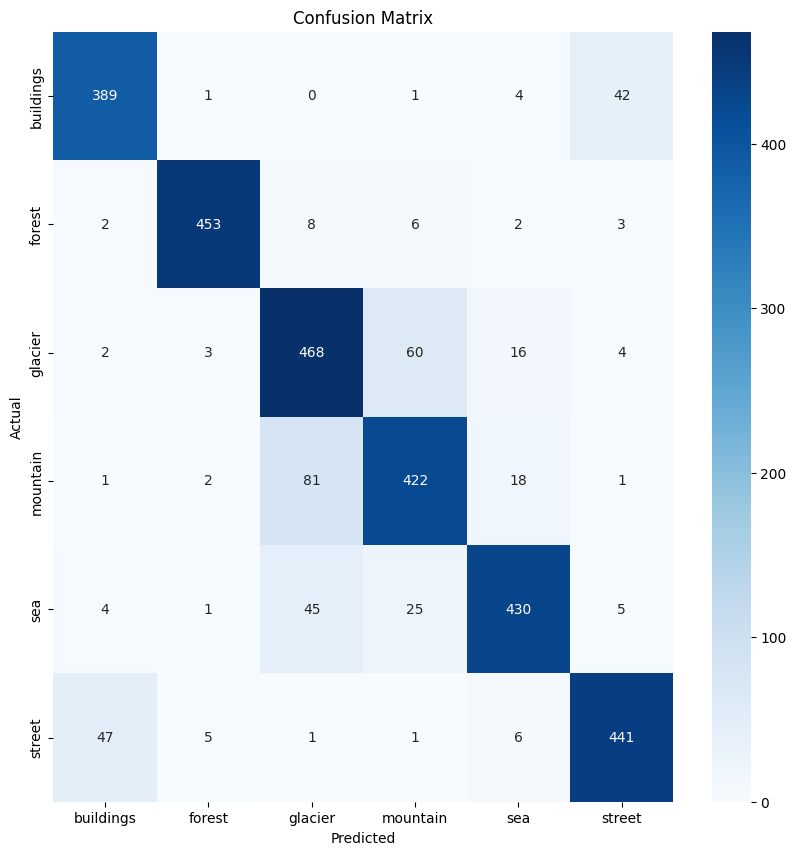

In [6]:
# Model Evaluation

# f1 score, precision, recall, accuracy, confusion matrix, classification report, and ROC curve

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc

# F1 Score
f1 = f1_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("F1 Score: ", f1)

# Precision
precision = precision_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Precision: ", precision)

# Recall
recall = recall_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), average='weighted')
print("Recall: ", recall)

# Accuracy
accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))
print("Accuracy: ", accuracy)

# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))

for i in range(6):
    plt.plot(fpr[i], tpr[i], label=classes_names[i] + ' (AUC = ' + str(roc_auc[i]) + ')')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()

# Classification Report
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1), target_names=classes_names))

# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes_names, yticklabels=classes_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


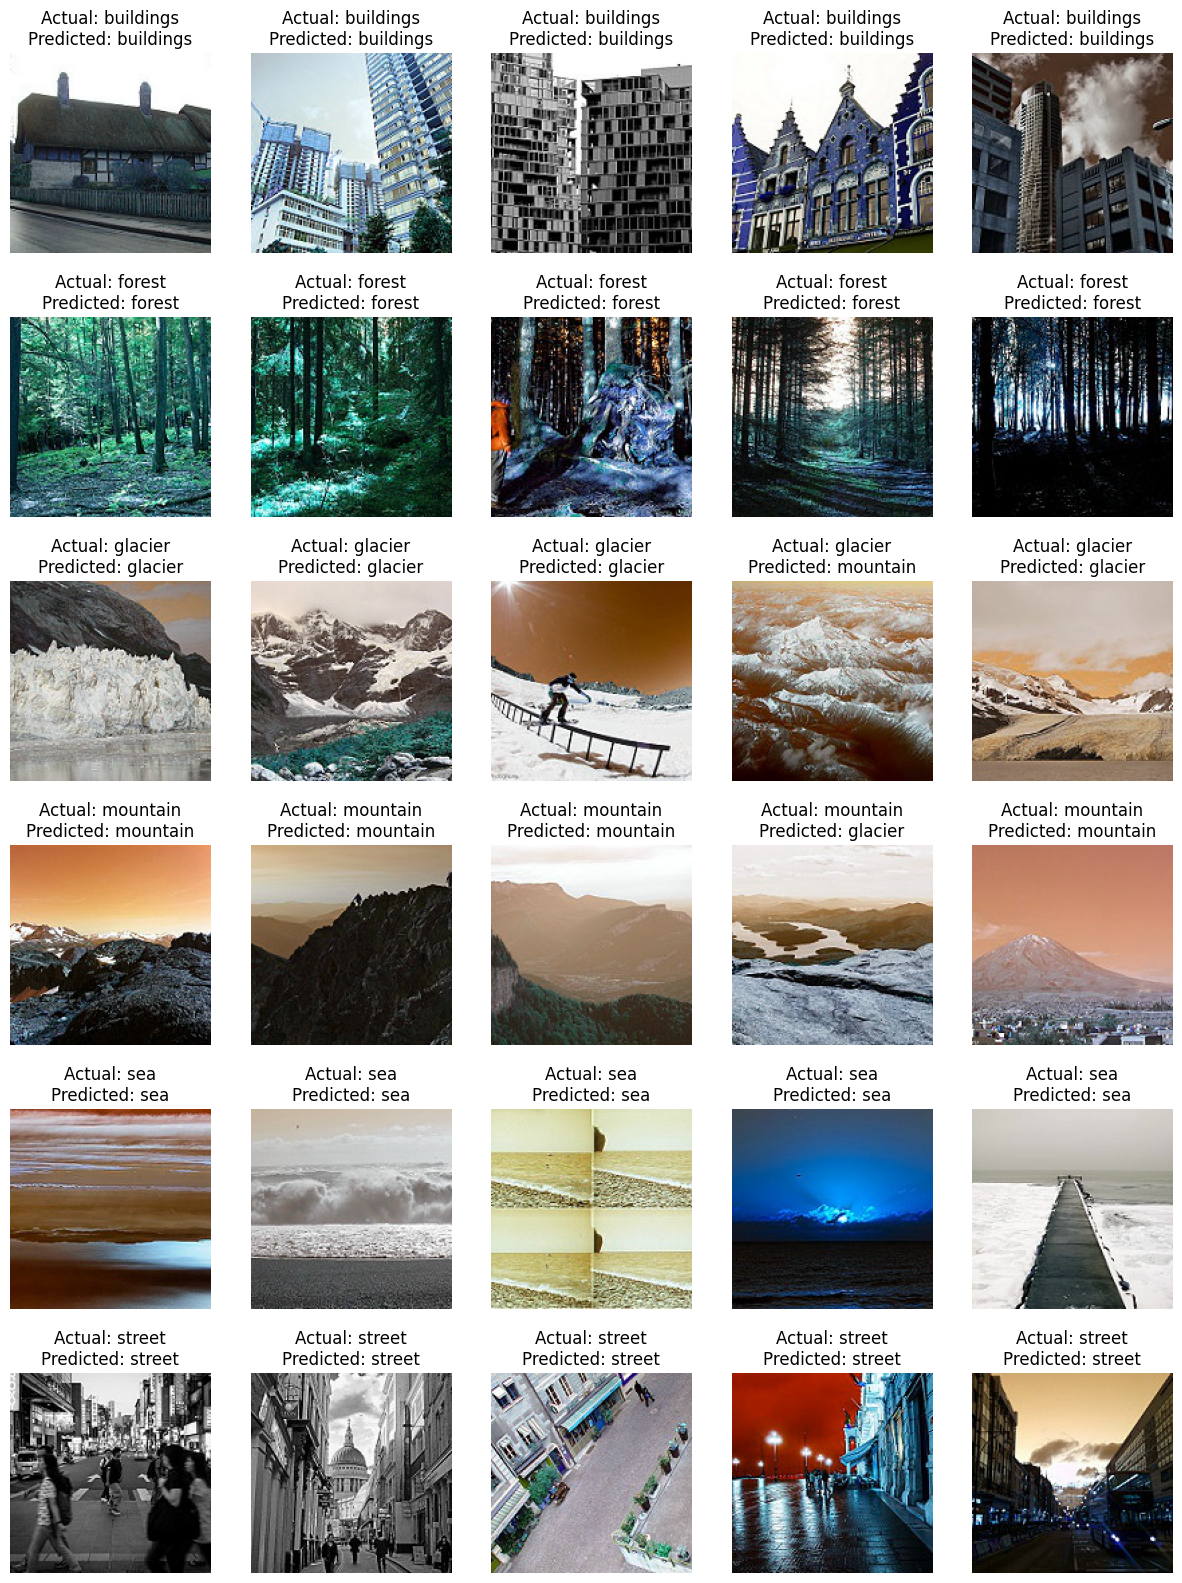

In [7]:
# Function to displaying random predictions from the dataset with their images and predictions

def display_random_predictions(X, y, predictions, classes_names, number_of_predictions=5):
    plt.figure(figsize=(15, 20))

    for class_name in classes_names:
        for i in range(number_of_predictions):
            index = np.random.choice(np.where(y == class_name)[0])
            plt.subplot(len(classes_names), number_of_predictions, number_of_predictions * list(classes_names).index(class_name) + i + 1)
            plt.imshow(X[index])
            plt.title("Actual: " + class_name + "\nPredicted: " + label_encoder.classes_[np.argmax(predictions[index])])
            plt.axis('off')
    
    plt.show()

display_random_predictions(X_test, y_test, predictions, classes_names)